In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<div style="padding: 6px 12px 18px 12px; background: #eeffee; border: 2px solid #88aa88; border-radius: 4px;">

<h2>Preface: Installing Devito (do not include in manuscipt)</h2>

<p>This tutorial and the coming second part are based on Devito version 3.1.0. It requires the installation of the full software with examples, not only the code generation API. To install:</p>

<pre style="background: #eeffee;">
  git clone -b v3.1.0 https://github.com/opesci/devito
  cd devito
  conda env create -f environment.yml
  source activate devito
  pip install -e .
</pre>

<p>That final dot is important, don't miss it out!</p>

<h3>Useful links</h3>

<ul>
<li><a href="http://www.opesci.org/">Devito documentation</a></li>
<li><a href="https://github.com/opesci/Devito">Devito source code and examples</a></li>
<li><a href="https://github.com/opesci/Devito/examples/seismic/tutorials">Tutorial notebooks with latest Devito/master</a></li>
</ul>

</div>

### Geophysics tutorial


# Full-waveform inversion 1: forward modeling

Mathias Louboutin<sup>1</sup>\*, Philipp Witte<sup>1</sup>, Michael Lange<sup>2</sup>, Navjot Kukreja<sup>2</sup>, Fabio Luporini<sup>2</sup>, Gerard Gorman<sup>2</sup>, and Felix J. Herrmann<sup>1,3</sup>

<sup>1</sup> Seismic Laboratory for Imaging and Modeling (SLIM), The University of British Columbia 

<sup>2</sup> Imperial College London, London, UK

<sup>3</sup> now at Georgia Institute of Technology, USA 

Corresponding author: mloubout@eoas.ubc.ca


Since its re-introduction by Pratt (1999), full-waveform inversion (FWI) has gained a lot of attention in geophysical exploration because of its ability to build high resolution velocity models more or less automatically in areas of complex geology. While there is an extensive and growing literature on the topic, publications focus mostly on technical aspects, making this topic inaccessible for a broader audience due to the lack of simple introductory resources for newcomers to geophysics. We will accomplish this by providing a hands-on walkthrough of FWI using Devito (Lange et al. 2016), a system based on domain-specific languages that automatically generates code for time-domain finite-differences.

As usual, this tutorial is accompanied by all the code you need to reproduce the figures. Go to github.com/seg/tutorials-2017 and follow the links. In the Notebook, we describe how to simulate synthetic data for a specified source and receiver setup and how to save the corresponding wavefields and shot records. In part two of this series, we will address how to calculate model updates, i.e. gradients of the FWI objective function, via adjoint modeling. Finally, in part three we will demonstrate how to use this gradient as part of an optimization framework for inverting an unknown velocity model.


## Introduction

Devito provides a concise and straightforward computational framework for discretizing wave equations, which underlie all FWI frameworks. We will show that it generates verifiable executable code at run time for wave propagators associated with forward and (in part 2) adjoint wave equations. Devito frees the user from the recurrent and time-consuming development of performant time-stepping codes and allows the user to concentrate on the geophysics of the problem rather than on low-level implementation details of wave-equation simulators. This tutorial covers the conventional adjoint-state formulation of full-waveform tomography (Tarantola 1984) that underlies most of the current methods referred to as full-waveform inversion (Virieux and Operto 2009). While other formulations have been developed to improve the convergence of FWI for poor starting models, in these tutorials we will concentrate on the standard formulation that relies on the combination of a forward/adjoint pair of propagators and a correlation-based gradient. In part one of this tutorial, we discuss how to set up wave simulations for inversion, including how to express the wave equation in Devito symbolically and how to deal with the acquisition geometry.

<div style="padding: 12px 12px 18px 12px; margin: 20px 0px 20px 0px; background: #eeeeff; border: 2px solid #8888aa; border-radius: 4px;">
<h4>What is FWI?</h4>
<p>FWI tries to iteratively minimize the difference between data that was acquired in a seismic survey and synthetic data that is generated from a wave simulator with an estimated (velocity) model of the subsurface. As such, each FWI framework essentially consists of a wave simulator for forward modeling the predicted data and an adjoint simulator for calculating a model update from the data misfit. This first part of this tutorial is dedicated to the forward modeling part and demonstrates how to discretize and implement the acoustic wave equation using Devito.</p>
</div>


## Wave simulations for inversion

The acoustic wave equation with the squared slowness $m$, defined as $m(x,y)=c^{-2}(x,y)$ with $c(x,y)$ being the unknown spatially varying wavespeed, is given by:

$$
m(x, y) \frac{\mathrm{d}^2 u(t, x, y)}{\mathrm{d}t^2}\ -\ \Delta u(t, x, y)\ +\ \eta(x, y) \frac{\mathrm{d} u(t, x, y)}{\mathrm{d}t}\ \  =\ \  q(t, x, y; x_\mathrm{s}, y_\mathrm{s}),\ \ \ \ \ \ \ \ (1)
$$

where $\Delta$ is the Laplace operator, $q(t, x, y;x_\mathrm{s}, y_\mathrm{s})$ is the seismic source, located at $(x_\mathrm{s}, y_\mathrm{s})$ and $\eta(x, y)$ is a space-dependent dampening parameter for the absorbing boundary layer (Cerjan et al. 1985). As shown in Figure 1, the physical model is extended in every direction by `nbpml` grid points to mimic an infinite domain. The dampening term $\eta\, \mathrm{d}u/\mathrm{d}t$ attenuates the waves in the dampening layer and prevents waves from reflecting at the model boundaries. In Devito, the discrete representations of $m$ and $\eta$ are contained in a `model` object that contains a `grid` object with all relevant information such as the origin of the coordinate system, grid spacing, size of the model and dimensions `time, x, y`:

In [2]:
# FIGURE 1
from IPython.display import HTML
HTML("../Figures/Figure1_composed.svg")

> Figure 1: (a) Diagram showing the model domain, with the perfectly matched layer (PML) as an absorbing layer to attenuate the wavefield at the model boundary. (b) The example model used in this tutorial, with the source and receivers indicated. The grid lines show the cell boundaries.

In [3]:
# NOT FOR MANUSCRIPT
from examples.seismic import Model, plot_velocity, demo_model

N = (401, 401)

In [4]:
model = demo_model('layers-isotropic',             # A velocity model.
                   nlayers=6,
                   shape=N,  # Number of grid points.
                   spacing=(7.5, 7.5),  # Grid spacing in m.
                   nbl=80, space_order=8)      # boundary layer.
vp = model.vp.data

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


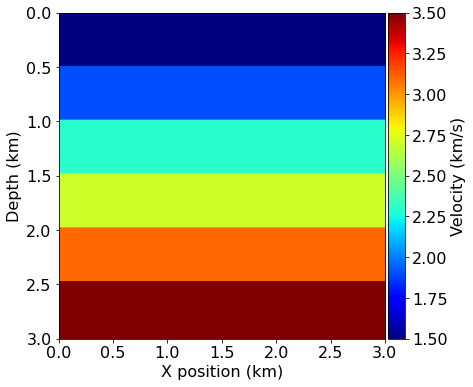

In [5]:
# NOT FOR MANUSCRIPT

# Quick plot of model.
plot_velocity(model)

In the `Model` instantiation, `vp` is the velocity in $\text{km}/\text{s}$, `origin` is the origin of the physical model in meters, `spacing` is the discrete grid spacing in meters, `shape` is the number of grid points in each dimension and `nbpml` is the number of grid points in the absorbing boundary layer. Is is important to note that `shape` is the size of the physical domain only, while the total number of grid points, including the absorbing boundary layer, will be automatically derived from `shape` and `nbpml`.

## Symbolic definition of the wave propagator

To model seismic data by solving the acoustic wave equation, the first necessary step is to discretize this partial differential equation (PDE), which includes discrete representations of the velocity model and wavefields, as well as approximations of the spatial and temporal derivatives using finite-differences (FD). Unfortunately, implementing these finite-difference schemes in low-level code by hand is error prone, especially when we want performant and reliable code. 

The primary design objective of Devito is to allow users to define complex matrix-free finite-difference approximations from high-level symbolic definitions, while employing automated code generation to create highly optimized low-level C code. Using the symbolic algebra package SymPy (Meurer et al. 2017) to facilitate the automatic creation of derivative expressions, Devito generates computationally efficient wave propagators.

At the core of Devito's symbolic API are symbolic types that behave like SymPy function objects, while also managing  data:

* `Function` objects represent a spatially varying function discretized on a regular Cartesian grid. For example, a function symbol `f = Function(name='f', grid=model.grid, space_order=2)` is denoted symbolically as `f(x, y)`. The objects provide auto-generated symbolic expressions for finite-difference derivatives through shorthand expressions like `f.dx` and `f.dx2` for the first and second derivative in `x`.

* `TimeFunction` objects represent a time-dependent function that has $\text{time}$ as the leading dimension, for example `g(time, x, y)`. In addition to spatial derivatives `TimeFunction` symbols also provide time derivatives `g.dt` and `g.dt2`.

* `SparseFunction` objects represent sparse components, such as sources and receivers, which are usually distributed sparsely and often located off the computational grid — these objects also therefore handle interpolation onto the model grid.

To demonstrate Devito's symbolic capabilities, let us consider a time-dependent function $\mathbf{u}(\text{time}, x, y)$ representing the discrete forward wavefield:

In [6]:
# NOT FOR MANUSCRIPT
from devito import TimeFunction
from examples.seismic import TimeAxis

t0 = 0.     # Simulation starts a t=0
tn = 3000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing

time = TimeAxis(start=t0, stop=tn, step=dt)

In [7]:
u = TimeFunction(name="u", grid=model.grid, 
                 time_order=2, space_order=8,
                 save=time.num)

where the `grid` object provided by the `model` defines the size of the allocated memory region, `time_order` and `space_order` define the default discretization order of the derived derivative expressions.

We can now use this symbolic representation of our wavefield to generate simple discretized expressions for finite-difference derivative approximations using shorthand expressions, such as `u.dt` and `u.dt2` to denote $\frac{\text{d} u}{\text{d} t}$ and $\frac{\text{d}^2 u}{\text{d} t^2}$ respectively:

In [8]:
# NOT FOR MANUSCRIPT
u

u(time, x, y)

In [9]:
u.dt

Derivative(u(time, x, y), time)

In [10]:
u.dt2

Derivative(u(time, x, y), (time, 2))

Using the automatic derivation of derivative expressions, we can now implement a discretized expression for Equation 1 without the source term $q(x,y,t;x_s, y_s)$. The `model` object, which we created earlier, already contains the squared slowness $\mathbf{m}$ and damping term $\mathbf{\eta}$ as `Function` objects:

In [11]:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

If we write out the (second order) second time derivative `u.dt2` as shown earlier and ignore the damping term for the moment, our `pde` expression translates to the following discrete the wave equation:

$$
 \frac{\mathbf{m}}{\text{dt}^2} \Big( \mathbf{u}[\text{time}-\text{dt}] - 2\mathbf{u}[\text{time}] + \mathbf{u}[\text{time}+\text{dt}]\Big) - \Delta \mathbf{u}[\text{time}] = 0, \quad \text{time}=1 \cdots n_{t-1} \ \ \ \ \ \ \ (2)
$$

with $\text{time}$ being the current time step and $\text{dt}$ being the time stepping interval. To propagate the wavefield, we rearrange to obtain an expression for the wavefield $\mathbf{u}(\text{time}+\text{dt})$ at the next time step. Ignoring the damping term once again, this yields:

$$
 \mathbf{u}[\text{time}+\text{dt}] = 2\mathbf{u}[\text{time}] - \mathbf{u}[\text{time}-\text{dt}] + \frac{\text{dt}^2}{\mathbf{m}} \Delta \mathbf{u}[\text{time}] \ \ \ \ \ \ \ (3)
$$

We can rearrange our `pde` expression automatically using the SymPy utility function `solve`, then create an expression which defines the update of the wavefield for the new time step $\mathbf{u}(\text{time}+\text{dt})$, with the command `u.forward`:

In [12]:
# NOT FOR MANUSCRIPT
from devito import Eq, solve

In [13]:
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(time + dt, x, y), (-(-2.0*u(time, x, y)/dt**2 + u(time - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(time, x, y), (x, 2)) + Derivative(u(time, x, y), (y, 2)) + damp(x, y)*u(time, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

`stencil` represents the finite-difference approximation derived from Equation 3, including the finite-difference approximation of the Laplacian and the damping term. Although it defines the update for a single time step only, Devito knows that we will be solving a time-dependent problem over a number of time steps because the wavefield `u` is a `TimeFunction` object.


## Setting up the acquisition geometry

The expression for time stepping we derived in the previous section does not contain a seismic source function yet, so the update for the wavefield at a new time step is solely defined by the two previous wavefields. However as indicated in Equation 1, wavefields for seismic experiments are often excited by an active (impulsive) source $q(x,y,t;x_\text{s})$, which is a function of space and time (just like the wavefield `u`). To include such a source term in our modeling scheme, we simply add the the source wavefield as an additional term to Equation 3:

$$
 \mathbf{u}[\text{time}+\text{dt}] = 2\mathbf{u}[\text{time}] - \mathbf{u}[\text{time}-\text{dt}] + \frac{\text{dt}^2}{\mathbf{m}} \Big(\Delta \mathbf{u}[\text{time}] + \mathbf{q}[\text{time}]\Big). \ \ \ \ \ \ \ (4)
$$

Since the source appears on the right-hand side in the original equation (Equation 1), the term also needs to be multiplied with $\frac{\text{dt}^2}{\mathbf{m}}$ (this follows from rearranging Equation 2, with the source on the right-hand side in place of 0). Unlike the discrete wavefield `u` however, the source `q` is typically localized in space and only a function of time, which means the time-dependent source wavelet is injected into the propagating wavefield at a specified source location. The same applies when we sample the wavefield at  receiver locations to simulate a shot record, i.e. the simulated wavefield needs to be sampled at specified receiver locations only. Source and receiver both do not necessarily coincide with the modeling grid.

Here, `RickerSource` acts as a wrapper around `SparseFunction` and models a Ricker wavelet with a peak frequency `f0` and source coordinates `src_coords`:

In [14]:
# NOT FOR MANUSCRIPT
from examples.seismic import RickerSource

# Src is halfway across model, at depth of 20 m.
x_extent, _ = model.domain_size
src_coords = [x_extent/2, 20]

In [15]:
f0 = 0.025  # kHz, peak frequency.
src = RickerSource(name='src', grid=model.grid, f0=f0, coordinates=src_coords, time_range=time)

The `src.inject` function now injects the current time sample of the Ricker wavelet (weighted with $\frac{\text{dt}^2}{\mathbf{m}}$ as shown in Equation 4) into the updated wavefield `u.forward` at the specified coordinates.

In [16]:
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

To extract the wavefield at a predetermined set of receiver locations, there is a corresponding wrapper function for receivers as well, which creates a `SparseFunction` object for a given number `npoint` of receivers, number `nt` of time samples, and specified receiver coordinates `rec_coords`:

In [17]:
# NOT FOR MANUSCRIPT
from examples.seismic import Receiver

# Recs are distributed across model, at depth of 20 m.
x_locs = np.linspace(0, x_extent, N[0])
rec_coords = [(x, 20) for x in x_locs]

In [18]:
rec = Receiver(name='rec', npoint=N[0], grid=model.grid, coordinates=rec_coords, time_range=time)

Rather than injecting a function into the model as we did for the source, we now simply save the wavefield at the grid points that correspond to receiver positions and interpolate the data to their exact possibly of the computatational grid location:

In [19]:
rec_term = rec.interpolate(u)

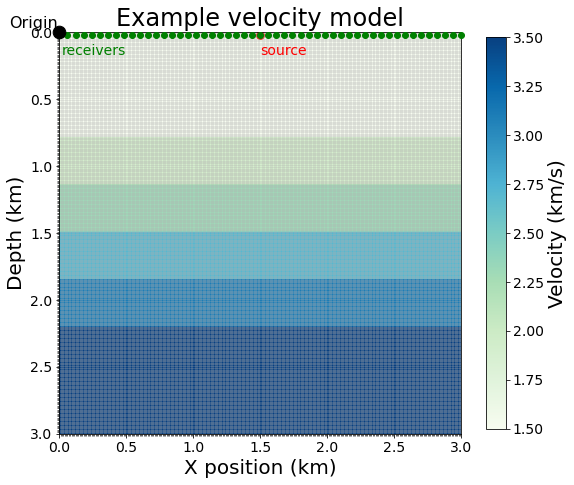

In [20]:
# NOT FOR MANUSCRIPT
# PLOTS HALF OF FIGURE 1.
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(9,9))

extent = [model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
          model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]]

model_param = dict(vmin=1.5, vmax=3.5, cmap="GnBu", aspect=1, extent=extent)

ax0 = fig.add_subplot(111)
im = plt.imshow(np.transpose(vp), **model_param)
cb = plt.colorbar(shrink=0.8)
ax0.set_ylabel('Depth (km)',fontsize=20)
ax0.set_xlabel('X position (km)', fontsize=20)
cb.set_label('Velocity (km/s)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cb.ax.tick_params(labelsize=14)

plt.scatter(*(rec.coordinates.data[::8, :].T/1000), c='green', clip_on=False, zorder=100)
plt.text(*rec.coordinates.data[0].T/1000 + [0.02, 0.15], "receivers", color='green', size=14)
plt.scatter(*(src.coordinates.data.squeeze()/1000), c='red', s=60)
plt.text(*src.coordinates.data[0]/1000 + [0, 0.15], "source", color='red', size=14)
plt.scatter(0, 0, c='black', s=160, clip_on=False, zorder=101)
plt.text(-0.01, -0.03, "Origin", color='k', size=16, ha="right")
plt.title("Example velocity model", color='k', size=24)
plt.xlim((0, 3))
plt.ylim((3, 0))

minorLocator = MultipleLocator(1/100)
ax0.xaxis.set_minor_locator(minorLocator)
ax0.yaxis.set_minor_locator(minorLocator)

plt.grid(which='minor', alpha=0.3)

plt.savefig("model.pdf", dpi=400)
plt.savefig("model.png")
plt.show()

## Forward simulation 

We can now define our forward propagator by adding the source and receiver terms to our stencil object:

In [21]:
# NOT FOR MANUSCRIPT
from devito import Operator

In [22]:
op_fwd = Operator([stencil] + src_term + rec_term)

The symbolic expressions used to create `Operator` contain sufficient meta-information for Devito to create a fully functional computational kernel. The dimension symbols contained in the symbolic function object (`time, x, y`) define the loop structure of the created code,while allowing Devito to automatically optimize the underlying loop structure to increase execution speed.

The size of the loops and spacing between grid points is inferred from the symbolic `Function` objects and associated `model.grid` object at run-time. As a result, we can invoke the generated kernel through a simple Python function call by supplying the number of timesteps `time` and the timestep size `dt`. The user data associated with each `Function` is updated in-place during operator execution, allowing us to extract the final wavefield and shot record directly from the symbolic function objects without unwanted memory duplication:

In [23]:
op_fwd(dt=model.critical_dt)

Operator `Kernel` ran in 1.24 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1.2107480000000017, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.010881999999999326, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.010887000000000278, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

When this has finished running, the resulting wavefield is stored in `u.data` and the shot record is in `rec.data`. We can easily plot this 2D array as an image, as shown in Figure 2.

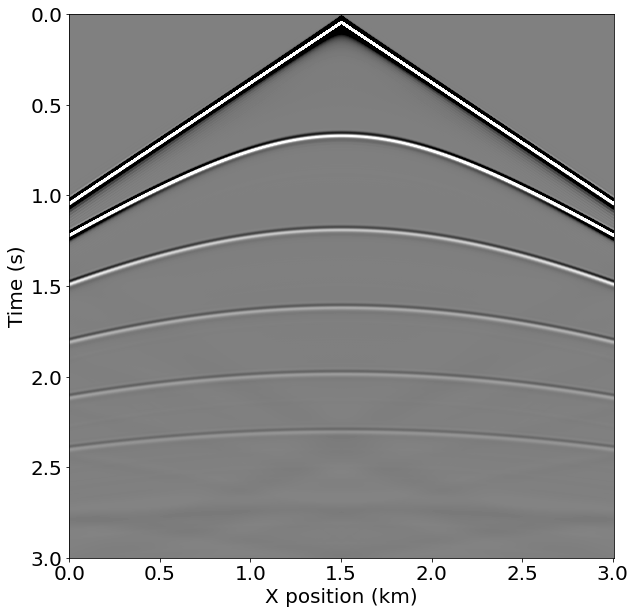

In [24]:
# NOT FOR MANUSCRIPT
# GENERATES FIGURE 2
from matplotlib import cm

fig1 = plt.figure(figsize=(10,10))
l = plt.imshow(rec.data, vmin=-.1, vmax=.1, cmap=cm.gray, aspect=1,
               extent=[model.origin[0], model.origin[0] + 1e-3*model.shape[0] * model.spacing[0],
                       1e-3*tn, t0])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Time (s)',  fontsize=20)
plt.tick_params(labelsize=20)

plt.savefig("Figure2.png", dpi=400)
plt.savefig("Figure2.pdf")
plt.show()

> Figure 2. The shot record generated by Devito for the example velocity model.

As demonstrated in the notebook, a movie of snapshots of the forward wavefield can also be generated by capturing the wavefield at discrete time steps. Figure 3 shows three timesteps from the movie.

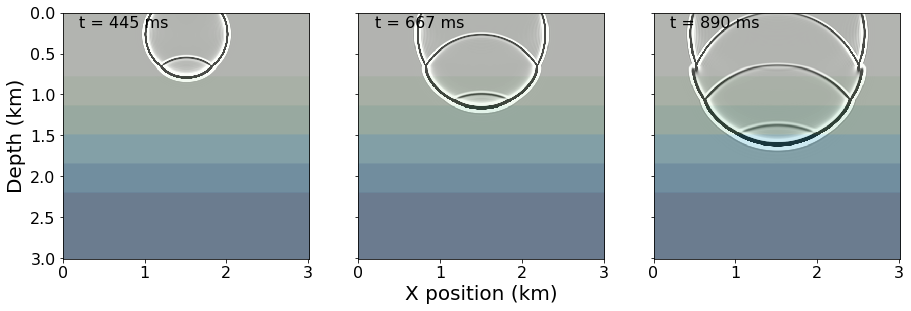

In [25]:
# NOT FOR MANUSCRIPT
# GENERATES FIGURE 3
fig = plt.figure(figsize=(15, 5))

times = [400, 600, 800]

extent = [model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
          model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]]

data_param = dict(vmin=-1e-1, vmax=1e-1, cmap=cm.Greys, aspect=1, extent=extent, interpolation='none')
model_param = dict(vmin=1.5, vmax=3.5, cmap=cm.GnBu, aspect=1, extent=extent, alpha=.3)

ax0 = fig.add_subplot(131)
_ = plt.imshow(np.transpose(u.data[times[0],40:-40,40:-40]), **data_param)
_ = plt.imshow(np.transpose(vp), **model_param)
ax0.set_ylabel('Depth (km)',  fontsize=20)
ax0.text(0.75, 0.18, "t = {:.0f} ms".format(time.time_values[times[0]]), ha="center", color='k')

ax1 = fig.add_subplot(132)
_ = plt.imshow(np.transpose(u.data[times[1],40:-40,40:-40]), **data_param)
_ = plt.imshow(np.transpose(vp), **model_param)
ax1.set_xlabel('X position (km)',  fontsize=20)
ax1.set_yticklabels([])
ax1.text(0.75, 0.18, "t = {:.0f} ms".format(time.time_values[times[1]]), ha="center", color='k')

ax2 = fig.add_subplot(133)
_ = plt.imshow(np.transpose(u.data[times[2],40:-40,40:-40]), **data_param)
_ = plt.imshow(np.transpose(vp), **model_param)
ax2.set_yticklabels([])
ax2.text(0.75, 0.18, "t = {:.0f} ms".format(time.time_values[times[2]]), ha="center", color='k')

plt.savefig("Figure3.pdf")
plt.savefig("Figure3.png", dpi=400)
plt.show()

> Figure 3. Three time steps from the wavefield simulation that resulted in the shot record in Figure 2. You can generate an animated version in the Notebook at github.com/seg.

In [26]:
# NOT FOR MANUSCRIPT
import matplotlib.animation as animation
from IPython.display import HTML

nt = time.num

fig = plt.figure()
im = plt.imshow(np.transpose(u.data[0,40:-40,40:-40]),
                cmap="Greys", animated=True, vmin=-1e-1, vmax=1e-1, aspect=1,
                extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                        model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
im2 = plt.imshow(np.transpose(vp), vmin=1.5, vmax=3.5, cmap=cm.GnBu, aspect=1,
                 extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                         model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]], alpha=.4)
def updatefig(i):
    im.set_array(np.transpose(u.data[i*5,40:-40,40:-40]))
    return im, im2

ani = animation.FuncAnimation(fig, updatefig, frames=np.linspace(0, nt/5-1, nt//5, dtype=np.int64), blit=True, interval=50)
plt.close(ani._fig)
HTML(ani.to_html5_video())

In [27]:
ani.save('animation.gif', writer='imagemagick', fps=30)

In [28]:
# from IPython.display import Image
# Image(url='../figures/animation.gif')

## Conclusions

In this first part of the tutorial, we have demonstrated how to set up the discretized forward acoustic wave equations and its associated wave propagator with runtime code generation. While we limited our discussion to the constant density acoustic wave equation, Devito is capable of handling more general wave equations but this is a topic beyond this tutorial on simulating waves for inversion. In part two of our tutorial, we will show how to calculate a valid gradient of the FWI objective using the adjoint state method. In part three, we will demonstrate how to set up a complete matrix-free and scalable optimization framework for acoustic FWI.


## Acknowledgments

This research was carried out as part of the SINBAD II project with the support of the member organizations of the SINBAD Consortium. This work was financially supported in part by EPSRC grant EP/L000407/1 and the Imperial College London Intel Parallel Computing Centre.


## References

Cerjan, C., Kosloff, D., Kosloff, R., and Reshef, M., 1985, A nonreflecting boundary condition for discrete acoustic and elastic wave equations: GEOPHYSICS, 50, 705–708. doi:10.1190/1.1441945

Lange, M., Kukreja, N., Louboutin, M., Luporini, F., Zacarias, F. V., Pandolfo, V., Gorman, G., 2016, Devito: Towards a generic finite difference DSL using symbolic python: 6th workshop on python for high-performance and scientific computing. doi:10.1109/PyHPC.2016.9

Meurer A, Smith CP, Paprocki M, et al., 2017, SymPy: symbolic computing in Python. PeerJ Computer Science 3:e103 https://doi.org/10.7717/peerj-cs.103

Pratt, R. G., 1999, Seismic waveform inversion in the frequency domain, part 1: Theory and verification in a physical scale model: GEOPHYSICS, 64, 888–901. doi:10.1190/1.1444597

Tarantola, A., 1984, Inversion of seismic reflection data in the acoustic approximation: GEOPHYSICS, 49, 1259–1266. doi:10.1190/1.1441754

Virieux, J., and Operto, S., 2009, An overview of full-waveform inversion in exploration geophysics: GEOPHYSICS, 74, WCC1–WCC26. doi:10.1190/1.3238367

<hr />
## Supplemental material

- [Devito documentation](http://www.opesci.org/)
- [Devito source code and examples](https://github.com/opesci/Devito)
- [Tutorial notebooks with latest Devito/master](https://github.com/opesci/Devito/examples/seismic/tutorials)

<hr> 

© 2017 The authors — licensed CC-BY-SA